# Pra-Pemrosesan Data:

Import Library


In [4]:
# === Visualisasi ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Fuzzy Logic ===
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# === Random Forest + Evaluation ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# === EDA + Preprocessing ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from scipy.stats import skew

import joblib
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Load dataset:

In [73]:
df = pd.read_csv("Crop_recommendation.csv")
print("🔍 Data Awal:")
print(df.head())

🔍 Data Awal:
    N   P   K  temperature  humidity      ph  rainfall label
0  90  42  43      20.8797   82.0027  6.5030  202.9355  rice
1  85  58  41      21.7705   80.3196  7.0381  226.6555  rice
2  60  55  44      23.0045   82.3208  7.8402  263.9642  rice
3  74  35  40      26.4911   80.1584  6.9804  242.8640  rice
4  78  42  42      20.1302   81.6049  7.6285  262.7173  rice


Cek missing values:


In [74]:
print("\n🚨 Cek Missing Values:")
print(df.isnull().sum())


🚨 Cek Missing Values:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


Handle missing values HANYA untuk kolom numerik:

In [75]:
numerik_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
df[numerik_cols] = df[numerik_cols].fillna(df[numerik_cols].mean())

print("\n✅ Missing value diisi (mean substitution untuk numerik):")
print(df.isnull().sum())


✅ Missing value diisi (mean substitution untuk numerik):
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


DETEKSI & DROP OUTLIER (IQR METHOD):

In [76]:
print("\n🔍 Deteksi Outlier (IQR) pada fitur numerik:")
for col in numerik_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    banyak_outlier = outlier_mask.sum()
    print(f"  • {col}: {banyak_outlier} outlier ditemukan")
    
    df = df[~outlier_mask]

df = df.reset_index(drop=True)
print(f"\n✅ Data setelah drop outlier, shape sekarang: {df.shape}")


🔍 Deteksi Outlier (IQR) pada fitur numerik:
  • N: 0 outlier ditemukan
  • P: 138 outlier ditemukan
  • K: 62 outlier ditemukan
  • temperature: 58 outlier ditemukan
  • humidity: 0 outlier ditemukan
  • ph: 58 outlier ditemukan
  • rainfall: 38 outlier ditemukan

✅ Data setelah drop outlier, shape sekarang: (1846, 8)


Atasi Skewness dari Rainfall:


🔧 Log-transform pada kolom 'rainfall' untuk mengurangi skewness:


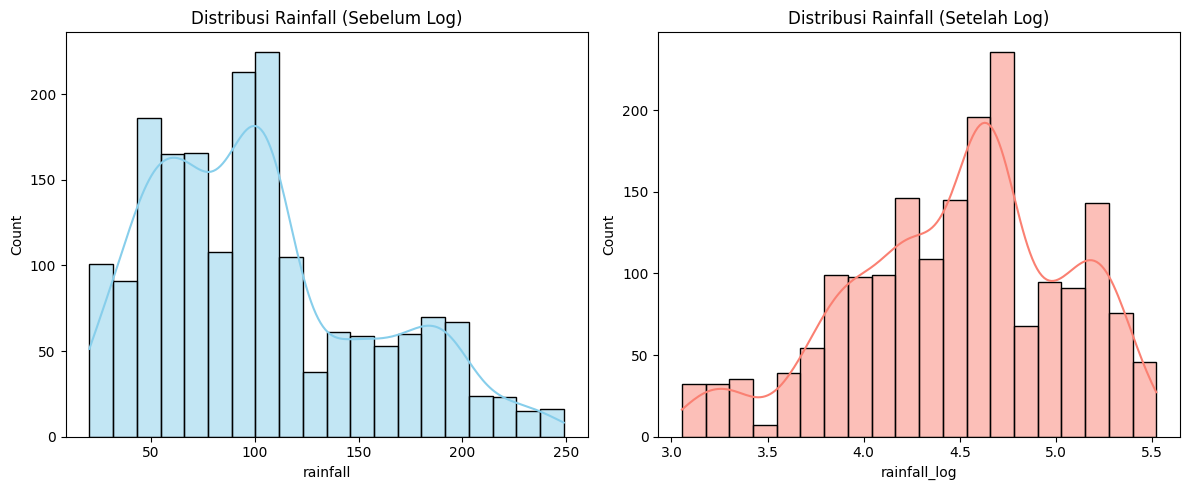


✅ Kolom 'rainfall' dihapus setelah log transform.


In [77]:
print("\n🔧 Log-transform pada kolom 'rainfall' untuk mengurangi skewness:")
df['rainfall_log'] = df['rainfall'].apply(lambda x: np.log1p(x))


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['rainfall'], bins=20, kde=True, color='skyblue')
plt.title("Distribusi Rainfall (Sebelum Log)")

plt.subplot(1, 2, 2)
sns.histplot(df['rainfall_log'], bins=20, kde=True, color='salmon')
plt.title("Distribusi Rainfall (Setelah Log)")
plt.tight_layout()
plt.show()

df = df.drop(columns=['rainfall'])
print("\n✅ Kolom 'rainfall' dihapus setelah log transform.")

FEATURE SELECTION BERDASARKAN KORELASI:

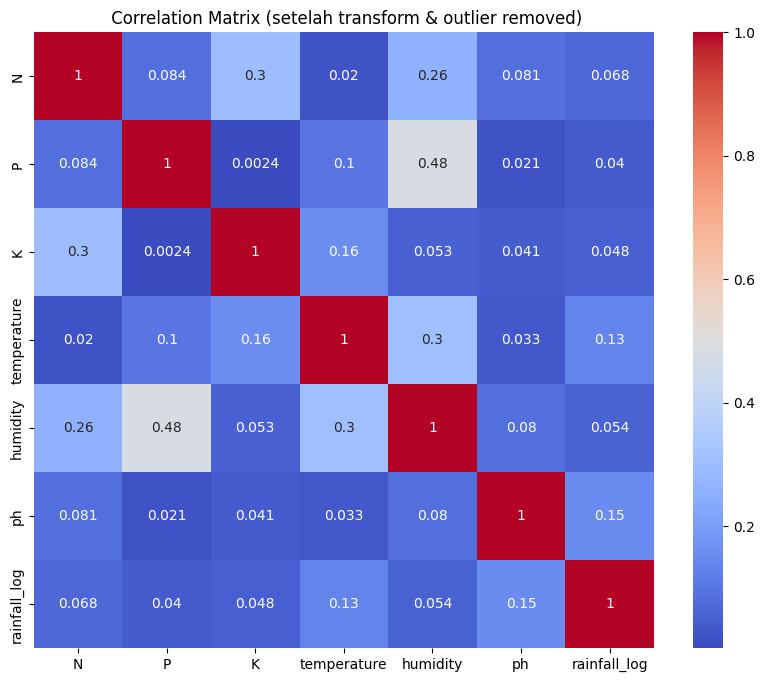


⚠️ Fitur yang akan di-drop karena korelasi tinggi (> 0.9):
[]

✅ Fitur setelah feature selection: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'label', 'rainfall_log']
   Shape sekarang: (1846, 8)


In [78]:
fitur_untuk_corr = [col for col in df.columns if col != 'label']
corr_matrix = df[fitur_untuk_corr].corr().abs()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title(" Correlation Matrix (setelah transform & outlier removed)")
plt.show()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
print("\n⚠️ Fitur yang akan di-drop karena korelasi tinggi (> 0.9):")
print(to_drop)

df_reduced = df.drop(columns=to_drop)
print(f"\n✅ Fitur setelah feature selection: {list(df_reduced.columns)}")
print(f"   Shape sekarang: {df_reduced.shape}")

NORMALISASI (MinMax Scaling ke [0,1]) pada fitur yang tersisa:

In [79]:
scaler = MinMaxScaler()
df_scaled = df_reduced.copy()
fitur_scaling = [col for col in df_reduced.columns if col not in ['label']]
df_scaled[fitur_scaling] = scaler.fit_transform(df_reduced[fitur_scaling])

feature_min = dict(zip(fitur_scaling, scaler.data_min_))
feature_max = dict(zip(fitur_scaling, scaler.data_max_))

print("\n🔧 Data Setelah Normalisasi (MinMax [0,1]):")
print(df_scaled[fitur_scaling].head())

# Validasi rentang normalisasi
print("\n🔍 Validasi rentang normalisasi:")
print(df_scaled[fitur_scaling].agg(['min', 'max']).T)


🔧 Data Setelah Normalisasi (MinMax [0,1]):
        N       P       K  temperature  humidity      ph  rainfall_log
0  0.6429  0.4111  0.4750       0.2591    0.7903  0.5004        0.9177
1  0.6071  0.5889  0.4500       0.3006    0.7706  0.6414        0.9623
2  0.5286  0.3333  0.4375       0.5210    0.7688  0.6262        0.9902
3  0.6714  0.5333  0.4375       0.2310    0.8007  0.2938        0.9887
4  0.6357  0.5444  0.4125       0.4288    0.8081  0.5485        0.9690

🔍 Validasi rentang normalisasi:
              min  max
N             0.0  1.0
P             0.0  1.0
K             0.0  1.0
temperature   0.0  1.0
humidity      0.0  1.0
ph            0.0  1.0
rainfall_log  0.0  1.0


SIMPAN DATA HASIL PREPROCESSING

In [80]:
df_scaled.to_csv("crop_preprocessed.csv", index=False)
print("\n💾 File hasil pra-pemrosesan disimpan sebagai 'crop_preprocessed.csv'")


💾 File hasil pra-pemrosesan disimpan sebagai 'crop_preprocessed.csv'


Filter dataset hanya untuk 3 label yang dipilih

In [81]:
df = pd.read_csv("crop_preprocessed.csv")
selected_labels = ['maize', 'coffee', 'coconut']
df_filtered = df[df['label'].isin(selected_labels)]

Simpan dataset baru:

In [82]:
df_filtered.to_csv("crop_filtered.csv", index=False)
print("✅ Dataset baru disimpan dengan label:", selected_labels)

✅ Dataset baru disimpan dengan label: ['maize', 'coffee', 'coconut']


# Fungsi Normalisasi Input:


In [83]:
def normalize_input(value, feature):
    """Normalisasi input pengguna ke skala 0–1 berdasarkan min/max dataset"""
    if feature not in feature_min or feature not in feature_max:
        raise ValueError(f"Fitur '{feature}' tidak dikenali")
    min_val = feature_min[feature]
    max_val = feature_max[feature]
    if max_val == min_val:  # Hindari pembagian nol
        return 0.0
    return (value - min_val) / (max_val - min_val)

# Exploratory Data Analysis

Statistik Deskriptif Sebelum Pra-pemrosesan:

In [84]:
df = pd.read_csv('Crop_Recommendation.csv', header=0)
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

stats_dict = {
    'Feature': [],
    'Mean': [],
    'Median': [],
    'Std Dev': [],
    'Min': [],
    'Max': [],
    'Skewness': [],
    'Kurtosis': []
}

for feature in features:
    data = df[feature].dropna()
    stats_dict['Feature'].append(feature)
    stats_dict['Mean'].append(data.mean())
    stats_dict['Median'].append(data.median())
    stats_dict['Std Dev'].append(data.std())
    stats_dict['Min'].append(data.min())
    stats_dict['Max'].append(data.max())
    stats_dict['Skewness'].append(skew(data))
    stats_dict['Kurtosis'].append(kurtosis(data))

stats_df = pd.DataFrame(stats_dict)

pd.set_option("display.precision", 4)

print(stats_df)

       Feature      Mean   Median  Std Dev      Min       Max  Skewness  \
0            N   50.5518  37.0000  36.9173   0.0000  140.0000    0.5094   
1            P   53.3627  51.0000  32.9859   5.0000  145.0000    1.0101   
2            K   48.1491  32.0000  50.6479   5.0000  205.0000    2.3735   
3  temperature   25.6162  25.5987   5.0637   8.8257   43.6755    0.1848   
4     humidity   71.4818  80.4731  22.2638  14.2580   99.9819   -1.0910   
5           ph    6.4695   6.4250   0.7739   3.5048    9.9351    0.2837   
6     rainfall  103.4637  94.8676  54.9584  20.2113  298.5601    0.9651   

   Kurtosis  
0   -1.0586  
1    0.8556  
2    4.4365  
3    1.2270  
4    0.2987  
5    1.6491  
6    0.6030  


Statistik Deskriptif Setelah Pra-pemrosesan:

In [85]:
df = pd.read_csv('crop_filtered.csv', header=0)
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall_log']

stats_dict = {
    'Feature': [],
    'Mean': [],
    'Median': [],
    'Std Dev': [],
    'Min': [],
    'Max': [],
    'Skewness': [],
    'Kurtosis': []
}

for feature in features:
    data = df[feature].dropna()
    stats_dict['Feature'].append(feature)
    stats_dict['Mean'].append(data.mean())
    stats_dict['Median'].append(data.median())
    stats_dict['Std Dev'].append(data.std())
    stats_dict['Min'].append(data.min())
    stats_dict['Max'].append(data.max())
    stats_dict['Skewness'].append(skew(data))
    stats_dict['Kurtosis'].append(kurtosis(data))

stats_df = pd.DataFrame(stats_dict)

pd.set_option("display.precision", 4)

print(stats_df)

        Feature    Mean  Median  Std Dev     Min     Max  Skewness  Kurtosis
0             N  0.4784  0.5429   0.2527  0.0000  0.8571   -0.3689   -1.1797
1             P  0.2930  0.2778   0.1690  0.0000  0.6111    0.1683   -0.8780
2             K  0.2722  0.2875   0.0727  0.1250  0.3750   -0.3917   -0.9564
3   temperature  0.4567  0.4803   0.1326  0.1266  0.6787   -0.7977    0.0908
4      humidity  0.6845  0.6162   0.1920  0.4175  1.0000    0.4270   -1.4204
5            ph  0.4568  0.4469   0.1334  0.2366  0.7613    0.3321   -0.7487
6  rainfall_log  0.7417  0.7796   0.1474  0.4326  0.9604   -0.5101   -0.8951


Histogram setelah Pra-pemrosesan

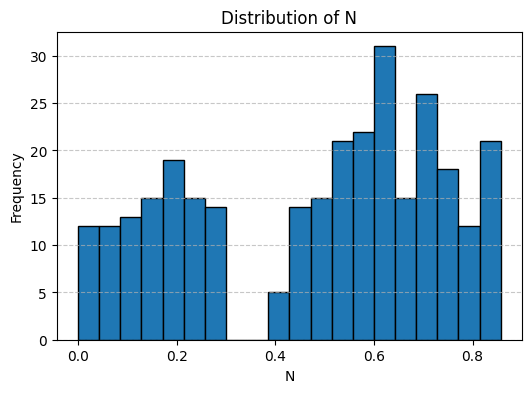

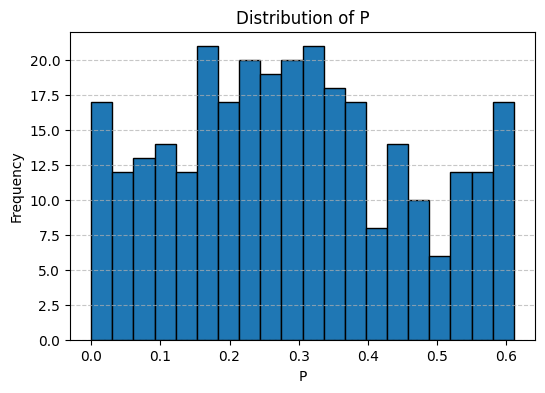

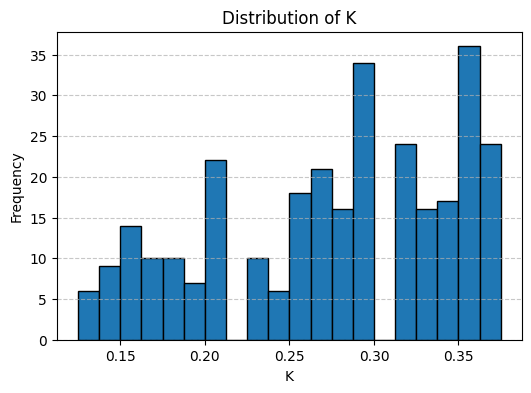

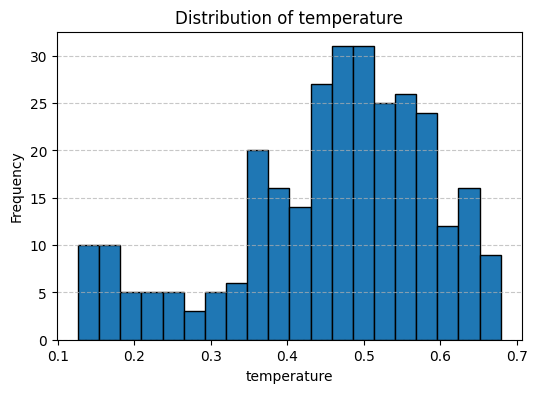

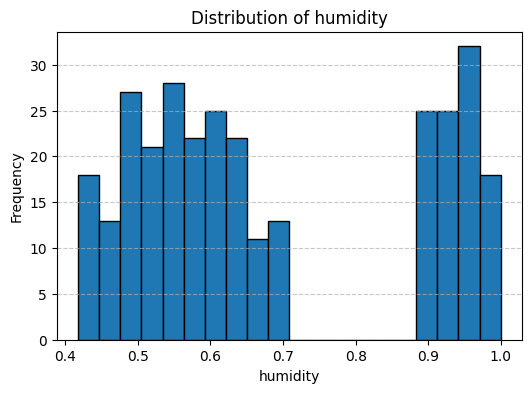

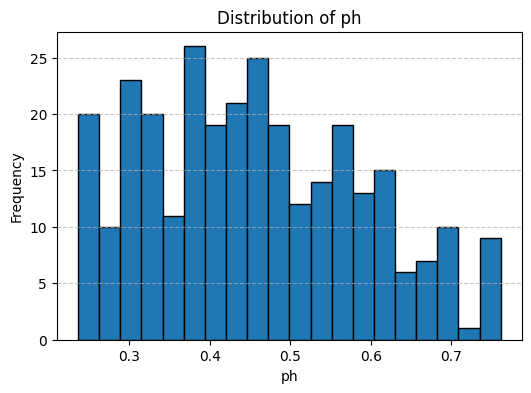

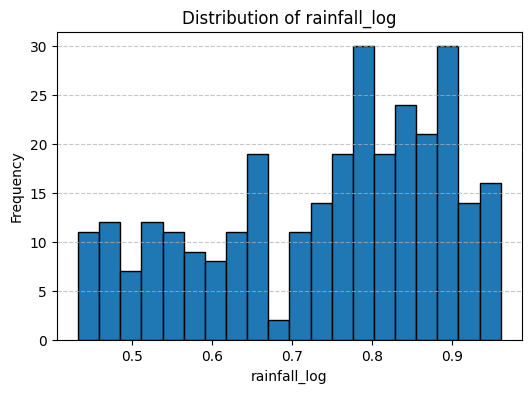

In [86]:
for feature in features:
    plt.figure(figsize=(6, 4))
    plt.hist(df[feature], bins=20, edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Distribusi untuk setiap label

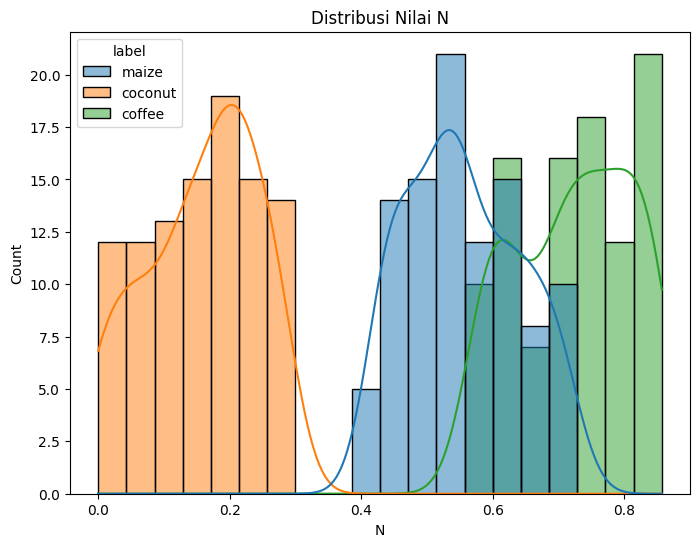

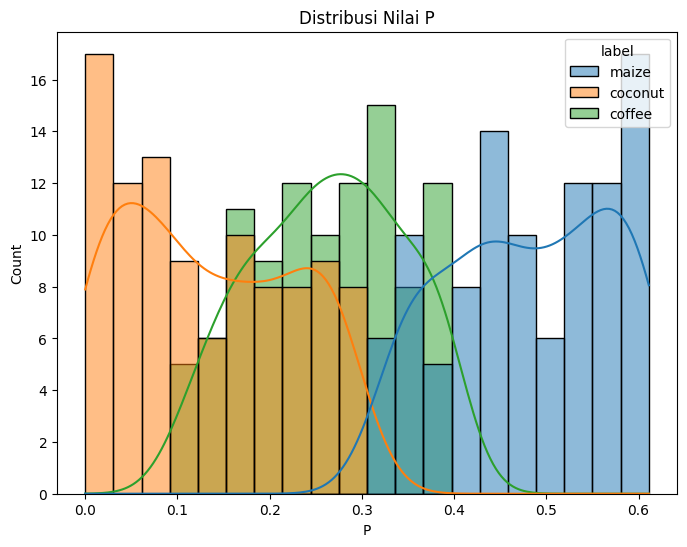

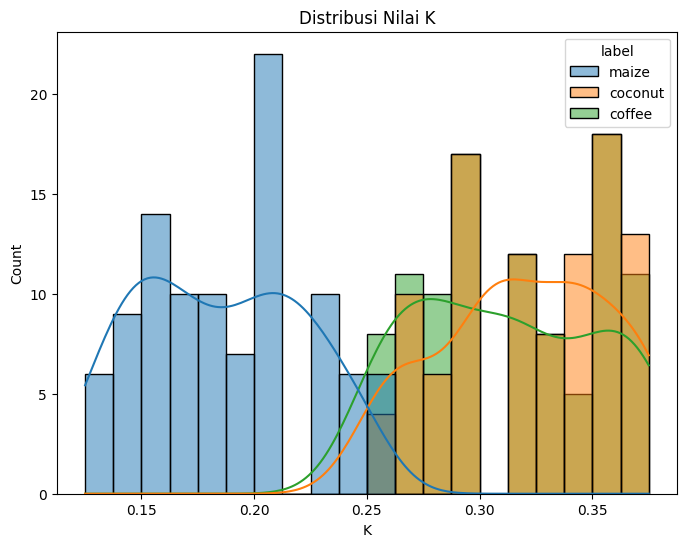

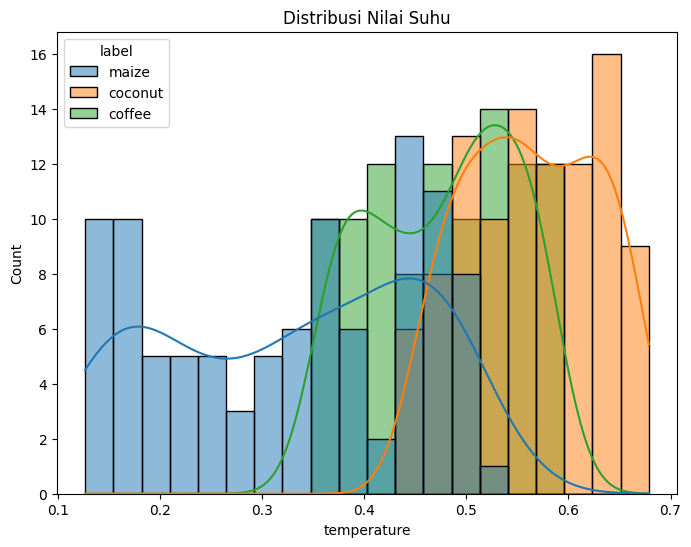

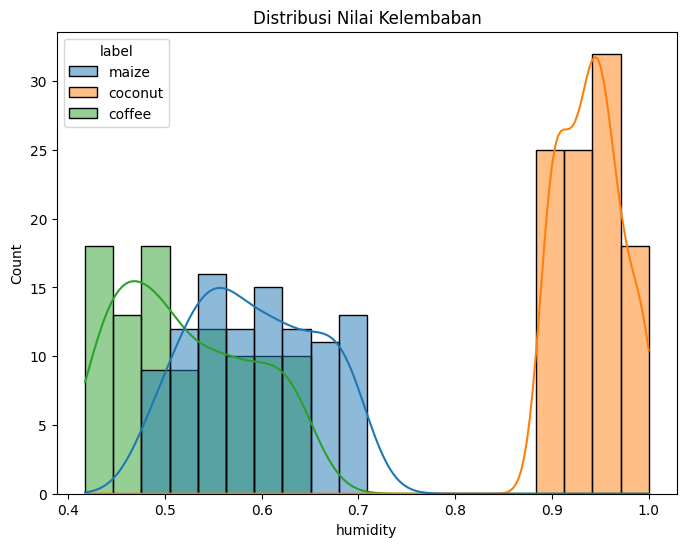

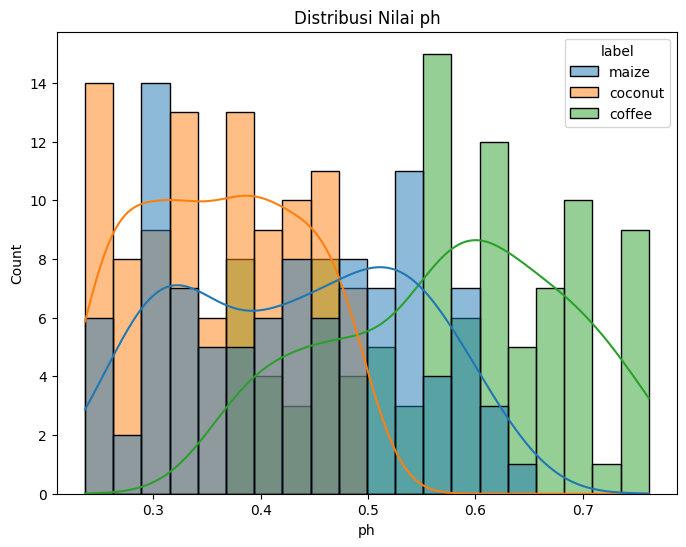

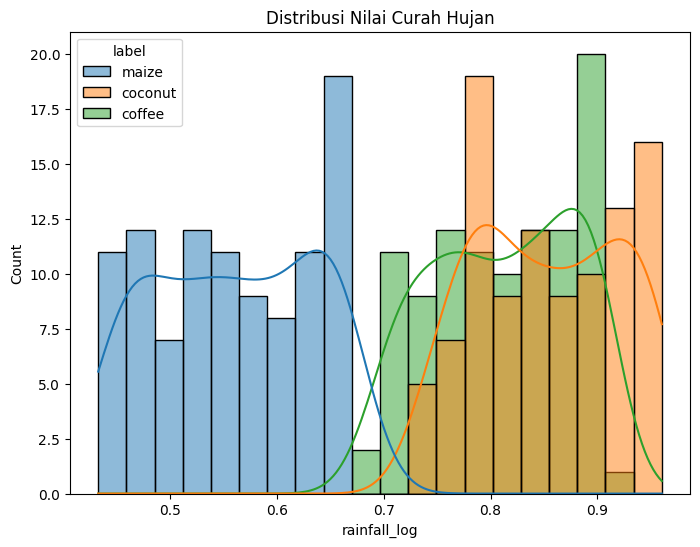

In [87]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='N', hue='label', kde=True, bins=20)
plt.title('Distribusi Nilai N')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='P', hue='label', kde=True, bins=20)
plt.title('Distribusi Nilai P')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='K', hue='label', kde=True, bins=20)
plt.title('Distribusi Nilai K')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='temperature', hue='label', kde=True, bins=20)
plt.title('Distribusi Nilai Suhu')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='humidity', hue='label', kde=True, bins=20)
plt.title('Distribusi Nilai Kelembaban')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='ph', hue='label', kde=True, bins=20)
plt.title('Distribusi Nilai ph')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='rainfall_log', hue='label', kde=True, bins=20)
plt.title('Distribusi Nilai Curah Hujan')
plt.show()


# Fuzzy Rules

In [88]:
# Maize rules (lebih spesifik pakai N, temperature, humidity, K, rainfall)
rules_maize = [
    ctrl.Rule(n['medium'] & temperature['low']    & humidity['medium'] & k['low'],    maize['good']),
    ctrl.Rule(n['medium'] & temperature['medium'] & k['medium']      & rainfall_log['low'], maize['average']),
    ctrl.Rule(rainfall_log['high'] | humidity['high'],                maize['poor']),
]

# Coffee rules (N, temperature, ph, K)
rules_coffee = [
    ctrl.Rule(n['high']   & temperature['medium'] & ph['medium'], coffee['good']),
    ctrl.Rule(n['medium'] & temperature['medium'] & k['high'],    coffee['average']),
    ctrl.Rule(n['low'] | ph['low'],                             coffee['poor']),
]

# Coconut rules (temperature, humidity, rainfall, K)
rules_coconut = [
    ctrl.Rule(temperature['high'] & humidity['high'] & rainfall_log['high'], coconut['good']),
    ctrl.Rule(k['medium']         & humidity['high'],                      coconut['average']),
    ctrl.Rule(humidity['low'] | rainfall_log['low'],                        coconut['poor']),
]

# Membership Function

In [89]:
N['low']    = fuzz.trapmf(N.universe, [0.0,   0.0,   0.22,  0.54])
N['medium'] = fuzz.trapmf(N.universe, [0.22,  0.54,  0.69,  0.85])
N['high']   = fuzz.trapmf(N.universe, [0.60,  0.70,  0.85,  0.85])

P['low']    = fuzz.trapmf(P.universe, [0.0,    0.0,    0.1667, 0.2778])
P['medium'] = fuzz.trapmf(P.universe, [0.1667, 0.2778, 0.4139, 0.6111])
P['high']   = fuzz.trapmf(P.universe, [0.2778, 0.4139, 0.6111, 0.6111])


K['low']    = fuzz.trapmf(K.universe, [0.1250, 0.1250, 0.2125, 0.2875])
K['medium'] = fuzz.trapmf(K.universe, [0.2125, 0.2875, 0.3375, 0.3750])
K['high']   = fuzz.trapmf(K.universe, [0.2875, 0.3375, 0.3750, 0.3750])

temperature['low']    = fuzz.trimf(temperature.universe, [0.00,   0.00,   0.40])
temperature['medium'] = fuzz.trimf(temperature.universe, [0.35,   0.50,   0.65])
temperature['high']   = fuzz.trimf(temperature.universe, [0.60,   1.00,   1.00])


humidity['low']    = fuzz.trapmf(humidity.universe, [0.4175, 0.4175, 0.5278, 0.6162])
humidity['medium'] = fuzz.trapmf(humidity.universe, [0.5278, 0.6162, 0.9128, 1.0])
humidity['high']   = fuzz.trapmf(humidity.universe, [0.6162, 0.9128, 1.0,    1.0])


ph['low']    = fuzz.trapmf(ph.universe, [0.2366, 0.2366, 0.3461, 0.4469])
ph['medium'] = fuzz.trapmf(ph.universe, [0.3461, 0.4469, 0.5600, 0.7613])
ph['high']   = fuzz.trapmf(ph.universe, [0.4469, 0.5600, 0.7613, 0.7613])


rainfall_log['low']    = fuzz.trapmf(rainfall_log.universe, [0.4326, 0.4326, 0.6346, 0.7796])
rainfall_log['medium'] = fuzz.trapmf(rainfall_log.universe, [0.6346, 0.7796, 0.8635, 0.9604])
rainfall_log['high']   = fuzz.trapmf(rainfall_log.universe, [0.7796, 0.8635, 0.9604, 0.9604])

C:\Users\SAMUEL KAUNANG\AppData\Local\Programs\Python\Python313\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


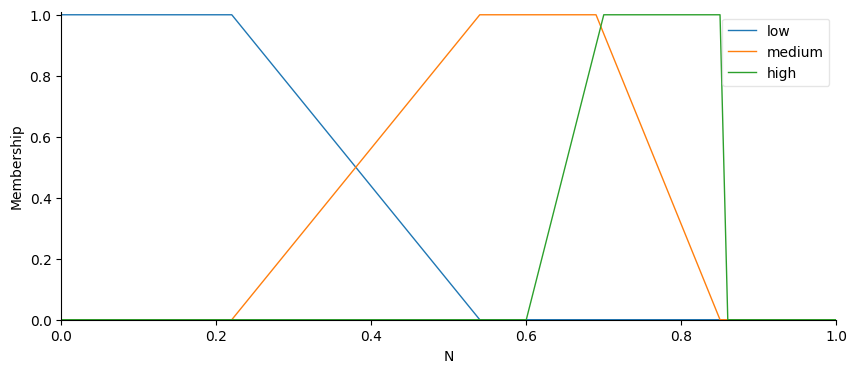

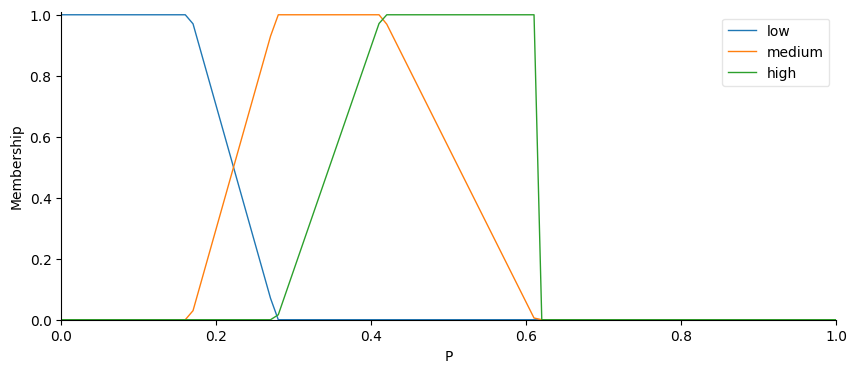

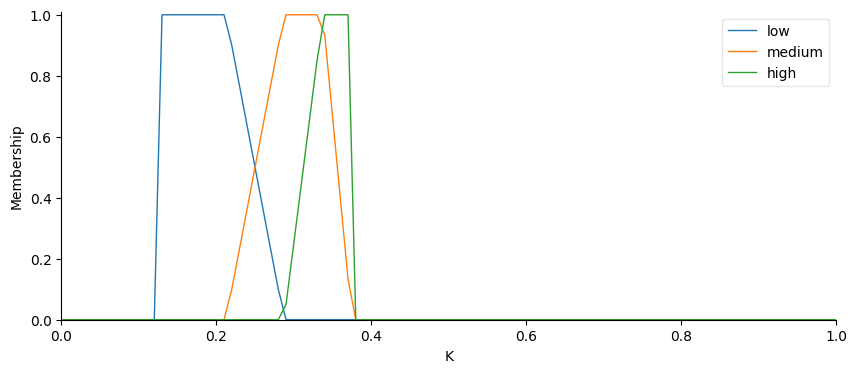

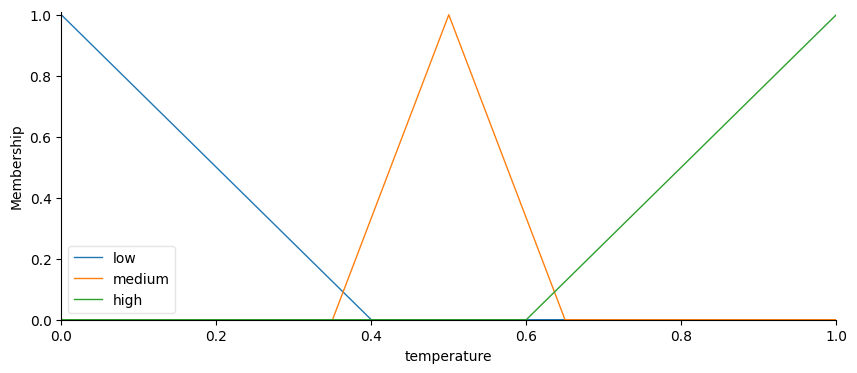

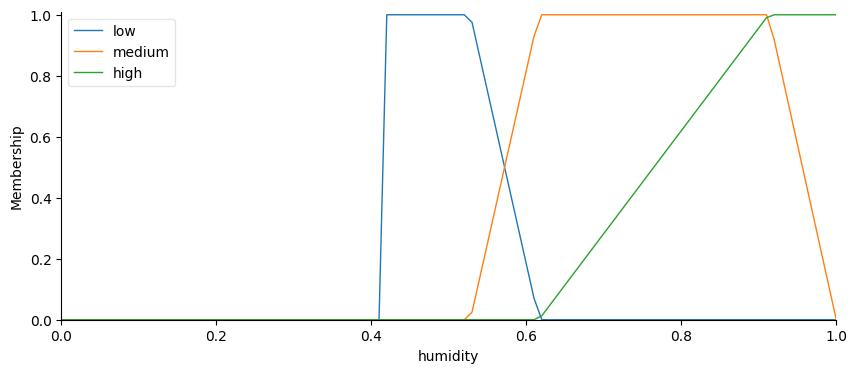

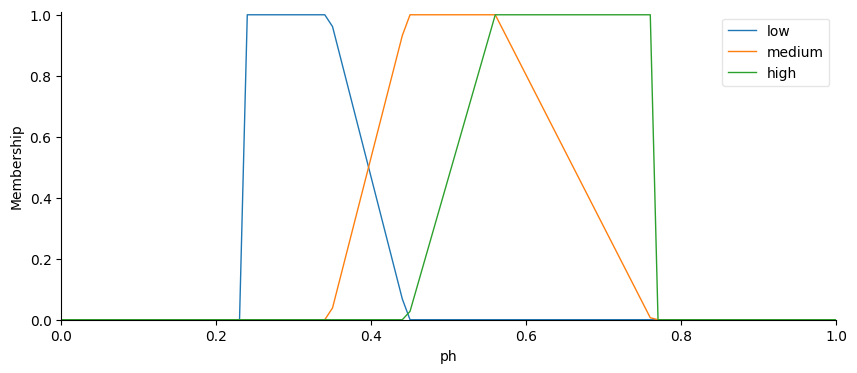

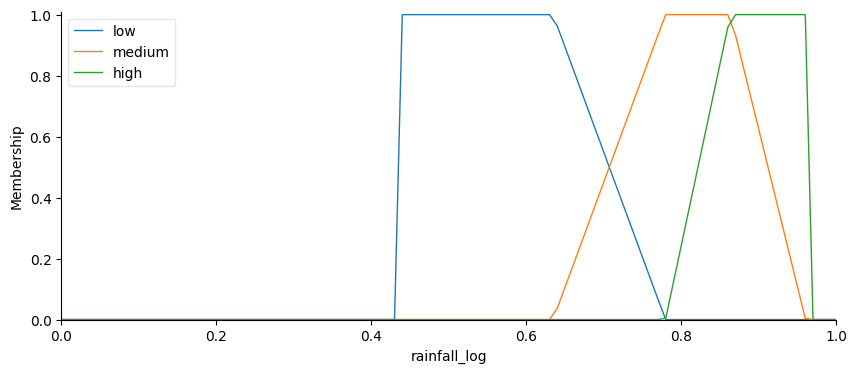

In [90]:


plt.rcParams['figure.figsize'] = [10, 4]

# Visualisasi semua variabel input
N.view()
P.view()
K.view()
temperature.view()
humidity.view()
ph.view()
rainfall_log.view()

plt.show()


# Sistem Rekomendasi Tanaman

In [91]:

df = pd.read_csv('crop_filtered.csv', header=0)
columns = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall_log', 'label']
df.columns = columns

# Variable Input
N = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'N')
P = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'P')
K = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'K')
temperature = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'temperature')
humidity = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'humidity')
rainfall_log = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'rainfall_log')
ph = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'ph')

N['low']    = fuzz.trapmf(N.universe, [0.0,   0.0,   0.22,  0.54])
N['medium'] = fuzz.trapmf(N.universe, [0.22,  0.54,  0.69,  0.85])
N['high']   = fuzz.trapmf(N.universe, [0.60,  0.70,  0.85,  0.85])

P['low']    = fuzz.trapmf(P.universe, [0.0,    0.0,    0.1667, 0.2778])
P['medium'] = fuzz.trapmf(P.universe, [0.1667, 0.2778, 0.4139, 0.6111])
P['high']   = fuzz.trapmf(P.universe, [0.2778, 0.4139, 0.6111, 0.6111])


K['low']    = fuzz.trapmf(K.universe, [0.1250, 0.1250, 0.2125, 0.2875])
K['medium'] = fuzz.trapmf(K.universe, [0.2125, 0.2875, 0.3375, 0.3750])
K['high']   = fuzz.trapmf(K.universe, [0.2875, 0.3375, 0.3750, 0.3750])

temperature['low']    = fuzz.trimf(temperature.universe, [0.00,   0.00,   0.40])
temperature['medium'] = fuzz.trimf(temperature.universe, [0.35,   0.50,   0.65])
temperature['high']   = fuzz.trimf(temperature.universe, [0.60,   1.00,   1.00])


humidity['low']    = fuzz.trapmf(humidity.universe, [0.4175, 0.4175, 0.5278, 0.6162])
humidity['medium'] = fuzz.trapmf(humidity.universe, [0.5278, 0.6162, 0.9128, 1.0])
humidity['high']   = fuzz.trapmf(humidity.universe, [0.6162, 0.9128, 1.0,    1.0])


ph['low']    = fuzz.trapmf(ph.universe, [0.2366, 0.2366, 0.3461, 0.4469])
ph['medium'] = fuzz.trapmf(ph.universe, [0.3461, 0.4469, 0.5600, 0.7613])
ph['high']   = fuzz.trapmf(ph.universe, [0.4469, 0.5600, 0.7613, 0.7613])


rainfall_log['low']    = fuzz.trapmf(rainfall_log.universe, [0.4326, 0.4326, 0.6346, 0.7796])
rainfall_log['medium'] = fuzz.trapmf(rainfall_log.universe, [0.6346, 0.7796, 0.8635, 0.9604])
rainfall_log['high']   = fuzz.trapmf(rainfall_log.universe, [0.7796, 0.8635, 0.9604, 0.9604])

# Definisikan Output
maize = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'maize')
coffee = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'coffee')
coconut = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'coconut')

for out in [maize, coffee, coconut]:
    out['poor']    = fuzz.trimf(out.universe, [0.0, 0.0, 0.5])
    out['average'] = fuzz.trimf(out.universe, [0.3, 0.5, 0.7])
    out['good']    = fuzz.trimf(out.universe, [0.6, 1.0, 1.0])



rules_maize = [
    ctrl.Rule(N['medium'] & temperature['low']    & humidity['medium'] & K['low'],    maize['good']),
    ctrl.Rule(N['medium'] & temperature['medium'] & K['medium']      & rainfall_log['low'], maize['average']),
    ctrl.Rule(rainfall_log['high'] | humidity['high'],                maize['poor']),
]


rules_coffee = [
    ctrl.Rule(N['high']   & temperature['medium'] & ph['medium'], coffee['good']),
    ctrl.Rule(N['medium'] & temperature['medium'] & K['high'],    coffee['average']),
    ctrl.Rule(N['low'] | ph['low'],                             coffee['poor']),
]


rules_coconut = [
    ctrl.Rule(temperature['high'] & humidity['high'] & rainfall_log['high'], coconut['good']),
    ctrl.Rule(K['medium']         & humidity['high'],                      coconut['average']),
    ctrl.Rule(humidity['low'] | rainfall_log['low'],                        coconut['poor']),
]

maize_ctrl   = ctrl.ControlSystem(rules_maize)
coffee_ctrl  = ctrl.ControlSystem(rules_coffee)
coconut_ctrl = ctrl.ControlSystem(rules_coconut)

maize_sim   = ctrl.ControlSystemSimulation(maize_ctrl)
coffee_sim  = ctrl.ControlSystemSimulation(coffee_ctrl)
coconut_sim = ctrl.ControlSystemSimulation(coconut_ctrl)


print("Masukkan kondisi agroklimat dalam satuan asli:")
inputs_real = {
    'N': float(input("Nitrogen (kg/ha): ")),
    'P': float(input("Phosphorus (kg/ha): ")),
    'K': float(input("Potassium (kg/ha): ")),
    'temperature': float(input("Suhu (°C): ")),
    'humidity': float(input("Kelembapan (%): ")),
    'rainfall_log': float(input("Curah Hujan (mm): ")),
    'ph': float(input("pH Tanah: "))
}

# NORMALISASI INPUT KE SKALA 0–1 
inputs_normalized = {
    'N': normalize_input(inputs_real['N'], 'N'),
    'P': normalize_input(inputs_real['P'], 'P'),
    'K': normalize_input(inputs_real['K'], 'K'),
    'temperature': normalize_input(inputs_real['temperature'], 'temperature'),
    'humidity': normalize_input(inputs_real['humidity'], 'humidity'),
    'rainfall_log': normalize_input(inputs_real['rainfall_log'], 'rainfall_log'),
    'ph': normalize_input(inputs_real['ph'], 'ph')
}


used_inputs = {
    'maize': ['temperature', 'humidity', 'K', 'rainfall_log'],
    'coffee': ['N', 'temperature', 'ph', 'K'],      # tambahin k karena di rules coffee ada k['high']
    'coconut': ['temperature', 'humidity', 'rainfall_log', 'K']
}

for var in used_inputs['maize']:
    maize_sim.input[var] = inputs_normalized[var]
for var in used_inputs['coffee']:
    coffee_sim.input[var] = inputs_normalized[var]
for var in used_inputs['coconut']:
    coconut_sim.input[var] = inputs_normalized[var]


try:
    maize_sim.compute()
    coffee_sim.compute()
    coconut_sim.compute()
except Exception as e:
    print("⚠️ Error dalam simulasi:", str(e))


scores = {
    'Maize':  maize_sim.output.get('maize', 0),
    'Coffee': coffee_sim.output.get('coffee', 0),
    'Coconut':coconut_sim.output.get('coconut', 0)
}
best = max(scores, key=scores.get)

print("\n✅ HASIL REKOMENDASI TANAMAN:")
for crop, val in scores.items():
    print(f"{crop:<10}: {val:.2f}")
print(f"\n🌿 Rekomendasi terbaik untuk ditanam: {best.upper()}")


Masukkan kondisi agroklimat dalam satuan asli:


Nitrogen (kg/ha):  31
Phosphorus (kg/ha):  6
Potassium (kg/ha):  26
Suhu (°C):  29
Kelembapan (%):  127
Curah Hujan (mm):  127
pH Tanah:  5



✅ HASIL REKOMENDASI TANAMAN:
Maize     : 0.17
Coffee    : 0.17
Coconut   : 0.50

🌿 Rekomendasi terbaik untuk ditanam: COCONUT


# Menghitung akurasi algoritma fuzzy berdasarkan tanaman (Maize, Coffee, Coconut)

In [3]:


df = pd.read_csv('crop_filtered.csv', header=0)

features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall_log']
X = df[features]
y_true = df['label'].str.lower().str.strip()

# Variable fuzzy
N = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'N')
P = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'P')
K = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'K')
temperature = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'temperature')
humidity = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'humidity')
ph = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'ph')
rainfall = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'rainfall_log')


N['low']    = fuzz.trapmf(N.universe, [0.0,   0.0,   0.22,  0.54])
N['medium'] = fuzz.trapmf(N.universe, [0.22,  0.54,  0.69,  0.85])
N['high']   = fuzz.trapmf(N.universe, [0.60,  0.70,  0.85,  0.85])

P['low'] = fuzz.trapmf(P.universe, [0.0, 0.0, 0.1667, 0.2778])
P['medium'] = fuzz.trapmf(P.universe, [0.1667, 0.2778, 0.4139, 0.6111])
P['high'] = fuzz.trapmf(P.universe, [0.2778, 0.4139, 0.6111, 0.6111])

K['low'] = fuzz.trapmf(K.universe, [0.1250, 0.1250, 0.2125, 0.2875])
K['medium'] = fuzz.trapmf(K.universe, [0.2125, 0.2875, 0.3375, 0.3750])
K['high'] = fuzz.trapmf(K.universe, [0.2875, 0.3375, 0.3750, 0.3750])

temperature['low']    = fuzz.trimf(temperature.universe, [0.00,   0.00,   0.40])
temperature['medium'] = fuzz.trimf(temperature.universe, [0.35,   0.50,   0.65])
temperature['high']   = fuzz.trimf(temperature.universe, [0.60,   1.00,   1.00])

humidity['low'] = fuzz.trapmf(humidity.universe, [0.4175, 0.4175, 0.5278, 0.6162])
humidity['medium'] = fuzz.trapmf(humidity.universe, [0.5278, 0.6162, 0.9128, 1.0])
humidity['high'] = fuzz.trapmf(humidity.universe, [0.6162, 0.9128, 1.0, 1.0])

ph['low']    = fuzz.trapmf(ph.universe, [0.2366, 0.2366, 0.3461, 0.4469])
ph['medium'] = fuzz.trapmf(ph.universe, [0.3461, 0.4469, 0.5600, 0.7613])
ph['high']   = fuzz.trapmf(ph.universe, [0.4469, 0.5600, 0.7613, 0.7613])

rainfall['low'] = fuzz.trapmf(rainfall.universe, [0.4326, 0.4326, 0.6346, 0.7796])
rainfall['medium'] = fuzz.trapmf(rainfall.universe, [0.6346, 0.7796, 0.8635, 0.9604])
rainfall['high'] = fuzz.trapmf(rainfall.universe, [0.7796, 0.8635, 0.9604, 0.9604])

# Definisikan Variable Output
maize_out = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'maize')
coffee_out = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'coffee')
coconut_out = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'coconut')

for out in [maize_out, coffee_out, coconut_out]:
    out['poor'] = fuzz.trimf(out.universe, [0.0, 0.0, 0.5])
    out['average'] = fuzz.trimf(out.universe, [0.3, 0.5, 0.7])
    out['good'] = fuzz.trimf(out.universe, [0.6, 1.0, 1.0])

# fuzzy rules
rules_maize = [
    ctrl.Rule(N['medium'] & temperature['low'] & humidity['medium'] & K['low'], maize_out['good']),
    ctrl.Rule(N['medium'] & temperature['medium'] & K['medium'] & rainfall['low'], maize_out['average']),
    ctrl.Rule(rainfall['high'] | humidity['high'], maize_out['poor']),
]

rules_coffee = [
    ctrl.Rule(N['high'] & temperature['medium'] & ph['medium'], coffee_out['good']),
    ctrl.Rule(N['medium'] & temperature['medium'] & K['high'], coffee_out['average']),
    ctrl.Rule(N['low'] | ph['low'], coffee_out['poor']),
]

rules_coconut = [
    ctrl.Rule(temperature['high'] & humidity['high'] & rainfall['high'], coconut_out['good']),
    ctrl.Rule(K['medium'] & humidity['high'], coconut_out['average']),
    ctrl.Rule(humidity['low'] | rainfall['low'], coconut_out['poor']),
]

maize_ctrl = ctrl.ControlSystem(rules_maize)
coffee_ctrl = ctrl.ControlSystem(rules_coffee)
coconut_ctrl = ctrl.ControlSystem(rules_coconut)

# Fungsi Prediksi
def predict_row(row):
    sim_maize = ctrl.ControlSystemSimulation(maize_ctrl)
    sim_coffee = ctrl.ControlSystemSimulation(coffee_ctrl)
    sim_coconut = ctrl.ControlSystemSimulation(coconut_ctrl)

    sim_maize.input['temperature'] = row['temperature']
    sim_maize.input['humidity'] = row['humidity']
    sim_maize.input['K'] = row['K']
    sim_maize.input['rainfall_log'] = row['rainfall_log']

    sim_coffee.input['N'] = row['N']
    sim_coffee.input['temperature'] = row['temperature']
    sim_coffee.input['ph'] = row['ph']

    sim_coconut.input['temperature'] = row['temperature']
    sim_coconut.input['humidity'] = row['humidity']
    sim_coconut.input['rainfall_log'] = row['rainfall_log']
    sim_coconut.input['K'] = row['K']

    try:
        sim_maize.compute()
        maize_score = sim_maize.output['maize']
    except:
        maize_score = 0

    try:
        sim_coffee.compute()
        coffee_score = sim_coffee.output['coffee']
    except:
        coffee_score = 0

    try:
        sim_coconut.compute()
        coconut_score = sim_coconut.output['coconut']
    except:
        coconut_score = 0

    scores = {
        'maize': maize_score,
        'coffee': coffee_score,
        'coconut': coconut_score
    }
    return max(scores, key=scores.get)

# Aplikasikan Prediksi
predictions = X.apply(predict_row, axis=1)

# Hitung akurasi
accuracy = accuracy_score(y_true, predictions)
print(f"\u2705 Akurasi sistem Fuzzy setelah update membership function: {accuracy * 100:.2f}%")


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predictions, labels=['maize','coffee','coconut'])
print(cm)

report = classification_report(
    y_true,
    predictions,
    labels=['coconut', 'coffee', 'maize'],
    target_names=['coconut', 'coffee', 'maize'],
    digits=2
)
print("\nClassification Report:")
print(report)


✅ Akurasi sistem Fuzzy setelah update membership function: 88.67%
[[ 73  27   0]
 [  6  93   1]
 [  0   0 100]]

Classification Report:
              precision    recall  f1-score   support

     coconut       0.99      1.00      1.00       100
      coffee       0.78      0.93      0.85       100
       maize       0.92      0.73      0.82       100

    accuracy                           0.89       300
   macro avg       0.90      0.89      0.89       300
weighted avg       0.90      0.89      0.89       300



# Random Forest(Model Pembanding)

5 row pertama dari dataset:
          N         P       K  temperature  humidity        ph  label  \
0  0.507143  0.544444  0.1375     0.340010  0.576650  0.302023  maize   
1  0.435714  0.433333  0.1500     0.502779  0.668621  0.613397  maize   
2  0.571429  0.422222  0.1375     0.384137  0.668839  0.541263  maize   
3  0.521429  0.588889  0.2000     0.216696  0.506565  0.524953  maize   
4  0.435714  0.366667  0.1875     0.146985  0.565035  0.360129  maize   

   rainfall_log  
0      0.580368  
1      0.641745  
2      0.470672  
3      0.432608  
4      0.462925   

Cross-Validation Accuracy (5-fold) - sebelum tuning hyperparameter:
CV Scores: [1. 1. 1. 1. 1.]
Rata-rata CV Accuracy: 1.0000

Memulai GridSearchCV untuk hyperparameter tuning...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Hasil terbaik dari GridSearchCV:
Best Params: {'rf__class_weight': None, 'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best CV Score: 1.0000

== Evaluas

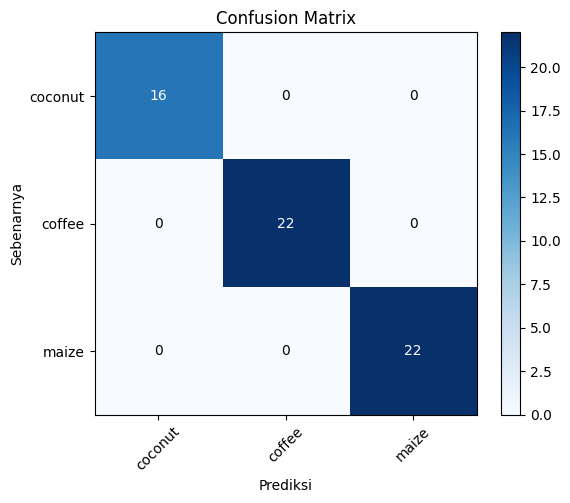


Feature Importances:
N: 0.2234
P: 0.0970
K: 0.1604
temperature: 0.0362
humidity: 0.2344
ph: 0.0437
rainfall_log: 0.2049


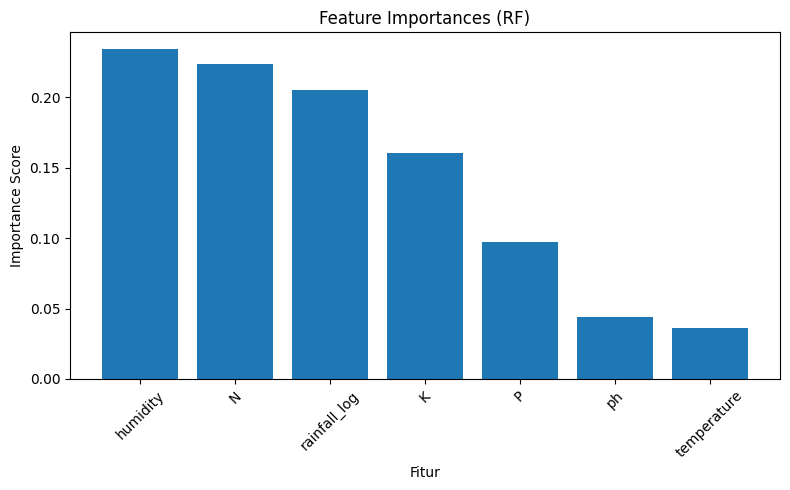

In [5]:
df = pd.read_csv('crop_filtered.csv')
print("5 row pertama dari dataset:")
print(df.head(), "\n")

# 2. Pisahin fitur dan label (misal bumbu vs menu utamanya)
X = df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall_log']]
y = df['label']

# 3. Split data jadi train & test (kayak bagi porsi buat dicoba langsung vs ditimbun cadangan)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Buat pipeline: scaling (StandardScaler) lalu RandomForest
#    Analogi: blender bumbu biar lembut dulu sebelum dimasak
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# 5. Cek performa dasar pake cross-validation (cicipin rasa di 5 piring)
print("Cross-Validation Accuracy (5-fold) - sebelum tuning hyperparameter:")
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV Scores: {cv_scores}")
print(f"Rata-rata CV Accuracy: {cv_scores.mean():.4f}\n")

# 6. Hyperparameter tuning (coba-coba takaran bumbu: n_estimators, max_depth, dll)
param_grid = {
    'rf__n_estimators': [100, 200],          # jumlah pohon di hutan
    'rf__max_depth': [None, 10, 20],         # seberapa dalam pohon tumbuh
    'rf__min_samples_split': [2, 5],         # minimal sampel buat satu split
    'rf__class_weight': [None, 'balanced']   # atur bobot kalau kelasnya imbang/nggak
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,                 # 3-fold CV buat GridSearch (bisa diubah sesuai resource)
    n_jobs=-1,            # pakai semua core CPU
    verbose=1
)

print("Memulai GridSearchCV untuk hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print("\nHasil terbaik dari GridSearchCV:")
print(f"Best Params: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}\n")

# 7. Pakai model terbaik dari grid search buat prediksi
best_model = grid_search.best_estimator_

# Latih ulang (biasanya GridSearchCV sudah fit di training, tapi buat jaga-jaga)
best_model.fit(X_train, y_train)

# 8. Prediksi di data test
y_pred = best_model.predict(X_test)

# 9. Evaluasi hasil
print("== Evaluasi di Data Test ==")
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi Test Set: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm, "\n")

# 10. Tampilkan Confusion Matrix sebagai heatmap sederhana (visual)
#     Analogi: kasih lampu senter biar kita tau area mana yang gelap/prediksi salah
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

# 11. Liat Feature Importance (bumbu mana yang paling ngegas rasa)
#     RandomForestClassifier ada attribute feature_importances_
feature_importances = best_model.named_steps['rf'].feature_importances_
features = X.columns

print("\nFeature Importances:")
for feat, imp in zip(features, feature_importances):
    print(f"{feat}: {imp:.4f}")

# Kalau mau plot feature importance juga bisa, misal:
plt.figure(figsize=(8, 5))
indices = np.argsort(feature_importances)[::-1]
plt.title("Feature Importances (RF)")
plt.bar(range(len(features)), feature_importances[indices], align='center')
plt.xticks(range(len(features)), features[indices], rotation=45)
plt.xlabel("Fitur")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()